In [1]:
#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

# %matplotlib inline

/Users/astasik/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


# Load and prepare the data

In [2]:
X_load = np.load('data/X.npy')
Y_load = np.load('data/Y.npy')

n_hidden=100

In [3]:
res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

In [4]:
def save_model(model, save_dir='models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    t = time.strftime("%Y%m%d-%H:%M:%S")
    path = os.path.join(save_dir, t+'.h5')  
    model.save(path)

    
def create_batch(X, Y, n_hidden=150):
    n_sets = X.shape[0]
    len_data = X.shape[-1]

    if n_sets == 1:
        n_set = 0
    else:
        n_set = np.random.randint(0, n_sets, 1)
    
    if n_hidden>len_data:
        raise Exception('Data set to short')
    random_start_point = np.random.randint(0, len_data-n_hidden)
    
    x = X[n_set, random_start_point:random_start_point+n_hidden]
    y = Y[n_set, random_start_point:random_start_point+n_hidden,:]
    return x,y

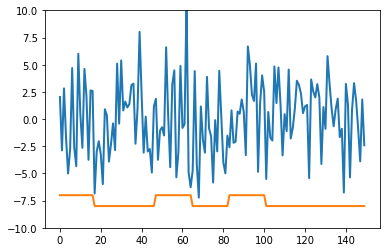

In [5]:
x,y = create_batch(X_load, Y_load, n_hidden=150)

plt.figure()
plt.plot(x, lw=2)
plt.plot(y[:,1]-8, lw=2)
plt.ylim(-10., 10.)
plt.show()

In [6]:
n_batches = 10000

X = np.zeros((n_batches, n_hidden, 1))
Y = np.zeros((n_batches, n_hidden, 2))

for i in range(n_batches):
    x,y = create_batch(X_load, Y_load, n_hidden=n_hidden)  
    X[i] = np.reshape(x, (x.shape[0], -1))
    Y[i] = y
    
    
train_input = X[:9000]
train_output = Y[:9000]
test_input = X[9000:]
test_output = Y[9000:]

In [7]:
train_input.shape

(9000, 100, 1)

In [8]:
n_dim = 1
input_shape = (None,n_dim)
batch_size = n_hidden

keras.backend.clear_session()
inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(inputs)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(loss=['categorical_crossentropy'],
              optimizer=keras.optimizers.Adam(lr=0.01))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
epochs = 20

history = model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs, 
                    verbose=True, validation_data=(test_input, test_output))

save_model(model)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.3986 - val_loss: 0.3275
Epoch 2/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.3238 - val_loss: 0.3099
Epoch 3/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.3157 - val_loss: 0.3052
Epoch 4/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.3073 - val_loss: 0.3027
Epoch 5/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2927 - val_loss: 0.2839
Epoch 6/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2743 - val_loss: 0.2710
Epoch 7/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2557 - val_loss: 0.2469
Epoch 8/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2329 - val_loss: 0.2420
Epoch 9/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.2150 - val_loss: 0.2235
Epoch 10/20
9000/9000 [==

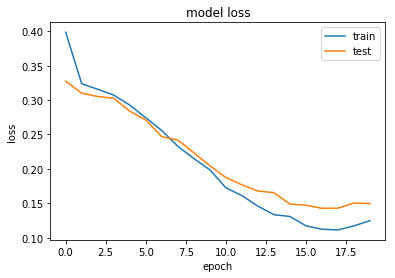

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [11]:
res = model.predict(test_input)

In [13]:
save_dir = 'plots'

if not os.path.exists(save_dir):
        os.makedirs(save_dir)

# for i in range(res.shape[0]):
for i in range(50):
    path = os.path.join(save_dir, str(i)+'.pdf')  
    plt.figure()
    plt.plot(test_input[i], lw=2)
    plt.plot(np.argmax(res[i], axis=1)-8, lw=2)
    plt.plot(np.argmax(test_output[i], axis=1)-8, lw=2)
    plt.ylim(-10., 10.)
    plt.savefig(path)
    plt.close()